In [1]:
#!/usr/bin/env python3
# -*- python -*-

import csv
import numpy as np
import pandas as pd
import html as parser
import matplotlib.pyplot as plt

from xml.etree import cElementTree
from html.parser import HTMLParser
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
def plot_distance_matrix(distance_matrix, labels):
    n = distance_matrix.shape[0]   
    plt.figure(figsize=(20,10))
    plt.imshow(distance_matrix, cmap='Blues')
    plt.xticks(range(n), labels, rotation=90)
    plt.yticks(range(n), labels)
    plt.colorbar()
    plt.show()
    
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,5))
    dendrogram(linkage_matrix, **kwargs)
    plt.show()


In [3]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def handle_starttag(self, tag, attrs):
        if tag == 'a':
            link = [value + ' ' for name,value in attrs if name == 'href']
            self.fed.extend(link)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    html = parser.unescape(html)
    s = MLStripper()
    s.feed(html)
    return s.get_data()

# Copy/paste from the help section on SEDE
# http://data.stackexchange.com/stackoverflow/query/new
def get_schema():
    schema = {
        'Id':                    np.uint,
        'PostTypeId':            np.uint8,
        'AcceptedAnswerId':      np.uint,
        'ParentId':              np.uint,
        'CreationDate':          np.str,
        'DeletionDate':          np.str,
        'Score':                 np.int,
        'ViewCount':             np.uint,
        'Body':                  np.str,
        'OwnerUserId':           np.uint,
        'OwnerDisplayName':      np.str,
        'LastEditorUserId':      np.uint,
        'LastEditorDisplayName': np.str,
        'LastEditDate':          np.str,
        'LastActivityDate':      np.str,
        'Title':                 np.str,
        'Tags':                  np.str,
        'AnswerCount':           np.uint,
        'CommentCount':          np.uint,
        'FavoriteCount':         np.uint,
        'ClosedDate':            np.str,
        'CommunityOwnedDate':    np.str,
    }
    return schema


def dump(fh):
    """
    Read a stream from FH, yield next Post row
    """
    schema = get_schema()
    events = cElementTree.iterparse(fh)
    for event, elem in events:
        if elem.tag != 'row':
            continue
        result = []
        for key, dtype in schema.items():
            try:
                result.append(elem.attrib[key])
            except KeyError:
                if dtype in [np.int, np.uint, np.uint8]:
                    result.append('0')
                elif 'date' in key.lower():
                    result.append('1970-01-01T00:00:00.000')
                else:
                    result.append('EMP')
        yield result
        elem.clear()

def parse_to_csv(infile='data/Posts.xml', outfile='data/posts.csv'):
    with open(infile, encoding='utf-8') as infile:
        writer = csv.writer(open(outfile, 'w', encoding='utf-8'))
        
        cnt = 0
        # write cols names first
        writer.writerow(get_schema().keys())
        for line in dump(infile):
            writer.writerow(line)
            cnt += 1
            
    print('Processed {} lines'.format(cnt))
    

In [4]:
def read_data(infile='data/posts.csv'):
    df = pd.read_csv(infile, encoding='utf-8')
    df = df.astype(dtype=get_schema())
    return df

def parse_data(df):
    """
    Parse the input data, removing html tags
    """
    df['Body'] = df['Body'].apply(lambda body: strip_tags(body))
    return df

In [2]:
parse_to_csv()

Processed 32830 lines


In [6]:
raw_df = read_data()
print(raw_df.columns)

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate'],
      dtype='object')


In [7]:
df = parse_data(raw_df)
df.loc[df['Title'] != 'EMP','Body'] = df['Title'] + '. ' + df['Body']
df = df.replace('EMP', '')
df = df[['Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'Score', 'Body', 'Tags']]
df.iloc[1:10,:]

,Id,PostTypeId,ParentId,AcceptedAnswerId,Score,Body,Tags
1,3,1,0,31,6,"If you kill someone who is committing suicide,...",<ethics>
2,4,2,1,0,109,"""http://en.wikipedia.org/wiki/Intuitionism Int...",
3,6,1,0,13,20,Is atheism a requirement for a consistent exis...,<existentialism><kierkegaard><atheism><sartre>...
4,8,1,0,0,6,"If we value free agency, how can punishment - ...",<state>
5,9,2,6,0,7,An existentialist philosophy is nothing more t...,
6,10,2,1,0,6,Mathematics is an abstraction. As such it is i...,
7,11,2,6,0,7,"God is negotiable under existential tenets, as...",
8,12,1,0,0,16,What's the difference between Randian philosop...,<ayn-rand><objectivism>
9,13,2,6,0,16,Perhaps a better question to ask is the invers...,


In [81]:
# some preprocessing to match questions with best answers
question_no_answer = df[(df['PostTypeId'] == 1) & (df['AcceptedAnswerId'] == 0)]
question_with_answer = df[(df['PostTypeId'] == 1) & (df['AcceptedAnswerId'] > 0)]
accepted_answer = df[(df['PostTypeId'] == 2) & (df['ParentId'].isin(question_with_answer['Id']))]
answer = df[(df['PostTypeId'] == 2) & (~df.index.isin(accepted_answer.index))]
answer = answer.sort_values(['ParentId', 'Score'], ascending=[True,False]).groupby(['ParentId']).first()
answer = answer.reset_index()

In [82]:
question_with_answer = pd.merge(question_with_answer, accepted_answer, left_on='AcceptedAnswerId', right_on='Id', how='left', suffixes=['_q','_a'])
question_no_answer = pd.merge(question_no_answer, answer, left_on='Id', right_on='ParentId', how='left', suffixes=['_q','_a'])

In [83]:
final_df = pd.concat([question_with_answer, question_no_answer]).reset_index()
final_df = final_df[['Id_q', 'Body_q', 'Id_a', 'Body_a']]

,Body_q,Id_a,Body_a
Id_q,,,
1,1,1,1
3,1,1,1
6,1,1,1
8,1,1,1
12,1,1,1
22,1,1,1
24,1,1,1
41,1,1,1
44,1,1,1


In [84]:
# just save everything in one big text file
with open('data/posts.txt', 'w', encoding='utf-8') as outfile:
    for bq, ba in zip(final_df['Body_q'], final_df['Body_a']): 
        outfile.write(u'{}'.format(bq))
        outfile.write(u'{}'.format(ba))
#         break

## Word2Vec based tagging of questions and answers
Having only one big network doing all the heavylift is probably going to perform pretty bad. After all, it's just appending random words one after another, with no knowledge of the topic of the discussion! One solution could be to use word2vec (or glove) word vectors to cluster questions by topic. A bunch of networks could then be trained on the different topics. So let's try to use the tags for the clustering...

In [44]:
import re

# check for unique tags
unique_tags = set(['none'])
for question_tags in df['Tags'].unique():
    tags = re.findall('<([a-zA-Z-]+)>', question_tags)
    unique_tags = unique_tags.union(set(tags))
    
unique_tags = sorted(list(unique_tags))
unique_tags

['abortion',
 'abstract',
 'absurdism',
 'adorno',
 'aesthetics',
 'affect',
 'agnosticism',
 'alienation',
 'altruism',
 'analogy',
 'analytic-philosophy',
 'analytic-synthetic-divide',
 'analyticity',
 'ancient',
 'ancient-philosophy',
 'animal-welfare',
 'animals',
 'anselm',
 'anthropology',
 'anti-realism',
 'applied-philosophy',
 'aquinas',
 'arendt',
 'argumentation',
 'aristotle',
 'arithmetic',
 'art',
 'artifact',
 'artificial-intelligence',
 'atheism',
 'atomism',
 'attitude',
 'authenticity',
 'awareness',
 'axiology',
 'ayn-rand',
 'badiou',
 'beauty',
 'being-and-time',
 'belief',
 'benjamin',
 'berkeley',
 'bertrand-russell',
 'bioethics',
 'bostrom',
 'brain-in-a-vat',
 'buddhism',
 'camus',
 'capitalism',
 'cassirer',
 'categorical-framework',
 'categorical-imperative',
 'causality',
 'causation',
 'charity',
 'charles-taylor',
 'chinese-philosophy',
 'chomsky',
 'christianity',
 'cicero',
 'classification',
 'cloning',
 'cognitive-psychology',
 'cognitive-sciences',
 

In [42]:
# import glove vectors to compute similarity between tags
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove_input_file = 'data/glove.6B.300d.txt'
word2vec_output_file = 'data/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) # './GoogleNews-vectors-negative300.bin'

In [77]:
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))
split_tags = [[tag for tag in ctag.split('-') if tag not in sw] for ctag in unique_tags]    
bad_tags = sorted([tag for ctag in split_tags for tag in ctag if tag not in model])
good_tags = [[tag for tag in ctag if tag not in bad_tags] for ctag in split_tags]

In [78]:
print(bad_tags)
print(good_tags)

['axiology', 'compatibilism', 'critque', 'dialetheism', 'goedel', 'holderlin', 'korsgaard', 'lucretious', 'mctaggert', 'merleau', 'metaethics', 'neurophilosophy', 'occams', 'paraconsistency', 'presocratics', 'untagged']
[['abortion'], ['abstract'], ['absurdism'], ['adorno'], ['aesthetics'], ['affect'], ['agnosticism'], ['alienation'], ['altruism'], ['analogy'], ['analytic', 'philosophy'], ['analytic', 'synthetic', 'divide'], ['analyticity'], ['ancient'], ['ancient', 'philosophy'], ['animal', 'welfare'], ['animals'], ['anselm'], ['anthropology'], ['anti', 'realism'], ['applied', 'philosophy'], ['aquinas'], ['arendt'], ['argumentation'], ['aristotle'], ['arithmetic'], ['art'], ['artifact'], ['artificial', 'intelligence'], ['atheism'], ['atomism'], ['attitude'], ['authenticity'], ['awareness'], [], ['ayn', 'rand'], ['badiou'], ['beauty'], ['time'], ['belief'], ['benjamin'], ['berkeley'], ['bertrand', 'russell'], ['bioethics'], ['bostrom'], ['brain', 'vat'], ['buddhism'], ['camus'], ['capi

In [107]:
from scipy.spatial.distance import cosine

tags = good_tags
# build a distance matrix for the tags, so we can cluster them in macro categories
nrows = len(tags)
ncols = nrows
dist_matrix = np.zeros((nrows, ncols))

for i in range(nrows):
    tag1_v = sum([model[tag] for tag in tags[i]])
    for j in range(i, ncols):
        tag2_v = sum([model[tag] for tag in tags[j]])
        dist = cosine(tag1_v, tag2_v)
        
        if np.isnan(dist):
            dist = 1
            
        dist_matrix[i,j] = dist
        
dist_matrix = dist_matrix + dist_matrix.transpose()
np.fill_diagonal(dist_matrix, 0)

C:\Users\daniele\AppData\Local\conda\conda\envs\ml\lib\site-packages\scipy\spatial\distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


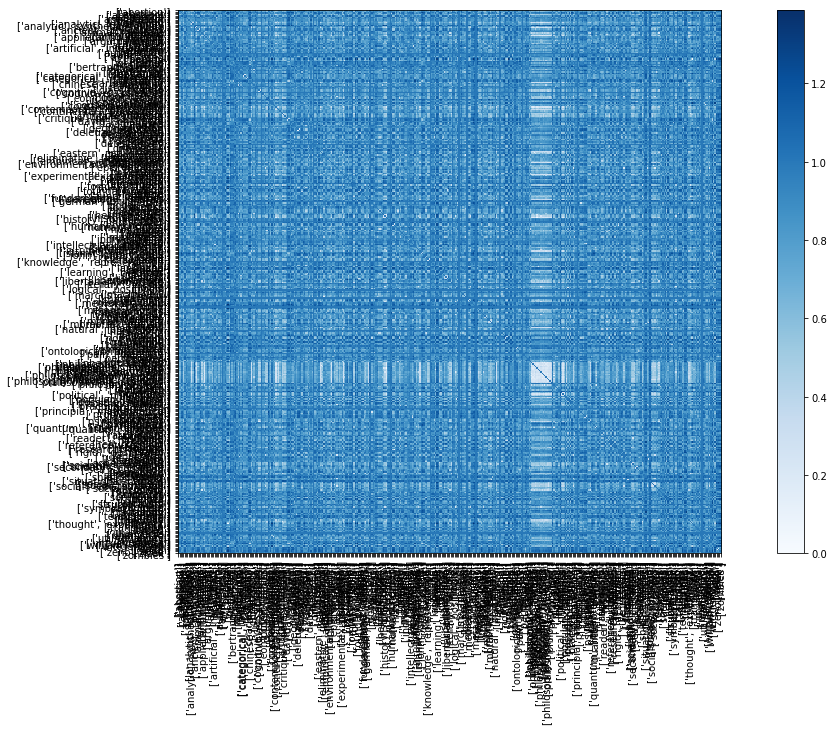

In [108]:
plot_distance_matrix(dist_matrix, tags)

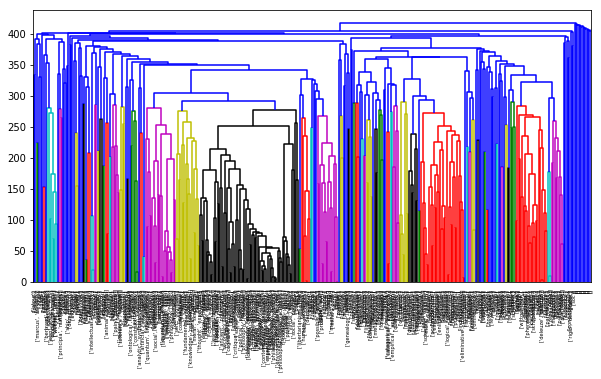

[(0, []), (0, []), (0, []), (0, []), (0, []), (1, ['abortion']), (1, ['abstract']), (1, ['absurdism']), (1, ['adorno']), (1, ['aesthetics']), (1, ['affect']), (1, ['agnosticism']), (1, ['alienation']), (1, ['altruism']), (1, ['analogy']), (1, ['analytic', 'philosophy']), (1, ['analytic', 'synthetic', 'divide']), (1, ['analyticity']), (1, ['ancient']), (1, ['ancient', 'philosophy']), (1, ['animal', 'welfare']), (1, ['animals']), (1, ['anselm']), (1, ['anthropology']), (1, ['anti', 'realism']), (1, ['applied', 'philosophy']), (1, ['aquinas']), (1, ['arendt']), (1, ['argumentation']), (1, ['aristotle']), (1, ['arithmetic']), (1, ['art']), (1, ['artifact']), (1, ['artificial', 'intelligence']), (1, ['atheism']), (1, ['atomism']), (1, ['attitude']), (1, ['authenticity']), (1, ['awareness']), (1, ['ayn', 'rand']), (1, ['badiou']), (1, ['beauty']), (1, ['belief']), (1, ['benjamin']), (1, ['berkeley']), (1, ['bertrand', 'russell']), (1, ['bioethics']), (1, ['bostrom']), (1, ['brain', 'vat']), 

In [109]:
cl = AgglomerativeClustering(n_clusters=10, linkage='average', affinity='precomputed', )
cl.fit(dist_matrix)
plot_dendrogram(cl, labels=tags)

print(sorted(zip(cl.labels_, tags)))

Apparently, tags are too generic or specific, and the similarity extracted from those is not very useful (see previous cell). Next idea is to use topic modeling to extract topics from the questions (and answers), and then predict the topic for the user's input. Different networks will then be generating different answers for different topics.

In [85]:
# Build a 'body' field for questions with answer (either accepted or most voted)
nans = pd.isna(final_df['Id_a'])

final_df['Doc'] = final_df['Body_q']
final_df.loc[~nans, 'Doc'] += '\n' + final_df.loc[~nans, 'Body_a']

final_df

,Id_q,Body_q,Id_a,Body_a,Doc
0,1,Was mathematics invented or discovered?. What ...,4.0,"""http://en.wikipedia.org/wiki/Intuitionism Int...",Was mathematics invented or discovered?. What ...
1,3,"If you kill someone who is committing suicide,...",31.0,An autonomy/consent perspective strongly disti...,"If you kill someone who is committing suicide,..."
2,6,Is atheism a requirement for a consistent exis...,13.0,Perhaps a better question to ask is the invers...,Is atheism a requirement for a consistent exis...
3,22,"What is the difference between ""necessary"" and...",55.0,"The difference between ""necessary"" and ""suffic...","What is the difference between ""necessary"" and..."
4,41,What is Philosophy?. What is a comprehensive d...,556.0,Philosophy is the practice of discovering new ...,What is Philosophy?. What is a comprehensive d...
5,44,Which philosophy forces others to act altruist...,276.0,Any moral theory can be interpreted as 'forcin...,Which philosophy forces others to act altruist...
6,45,What are the main points of criticism of the a...,158.0,First it must be said that hedonism in the mod...,What are the main points of criticism of the a...
7,66,A reference for understanding current trends i...,166.0,"To understand current epistemology, you need t...",A reference for understanding current trends i...
8,70,Could 'cogito ergo sum' possibly be false?. I'...,79.0,"The objection to ""I think, therefore I am"" is ...",Could 'cogito ergo sum' possibly be false?. I'...
9,77,Can you prove anything in philosophy?. I don't...,122.0,There are two categories of things that can be...,Can you prove anything in philosophy?. I don't...


Build the corpus for the LDA model. Only keep non-stopwords, removing all punctuation and making all lowercase.

In [163]:
import re

from gensim import models, corpora
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import pos_tag

sw = set(stopwords.words('english')).union(set(['say', 'could', 'would', 'should', 'shall'])).union(set(punctuation))
stemmer = SnowballStemmer('english')

url_re = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.IGNORECASE|re.DOTALL)

def preprocess(text):   
    def penn2morphy(penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN':'n', 'JJ':'a',
                      'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n' # if mapping isn't found, fall back to Noun.
    
    text = text.lower()
    text = url_re.sub('', text) # remove http links
    text = re.sub(r'([a-z0-9])\/([a-z0-9])', r'\1 \2', text) # convert 'a/b' to 'a or b'
    text = re.sub('[^a-z\s]', '', text)      # get rid of noise (punctuation, symbols, etc.)
    text = [lemmatizer.lemmatize(w, pos=penn2morphy(tag)) for w, tag in pos_tag(text.split()) if w not in sw]  # remove stopwords
    text = [w for w in text if len(w) >= 3]
    
    return text

def get_query_topic(query, dictionary):
    id2word = corpora.Dictionary()
    _ = id2word.merge_with(dictionary.id2token)
    
    query_topic = np.argmax([score for t,score in lda[query]])
    return query_topic

In [153]:
# print(preprocess('Test1/test2, and a link: https://en.wikipedia.org/MyPage.'))
docs = final_df['Doc'].apply(preprocess)

dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [154]:
rnd = np.random.choice(len(final_df))

# print(final_df.loc[rnd,'Body_q'])
print([(dictionary[w],f) for w,f in corpus[rnd]])

[('mathematics', 1), ('mind', 5), ('question', 1), ('say', 1), ('good', 1), ('interest', 1), ('think', 1), ('philosophy', 13), ('able', 1), ('problem', 1), ('sort', 1), ('time', 2), ('true', 1), ('first', 2), ('logic', 1), ('original', 1), ('work', 2), ('hear', 1), ('theory', 1), ('epistemology', 1), ('apply', 2), ('gain', 1), ('really', 1), ('understanding', 1), ('describe', 1), ('help', 1), ('several', 1), ('indepth', 1), ('language', 1), ('branch', 4), ('occasion', 1), ('mainly', 1), ('thoeries', 1)]


In [155]:
load_model = True
model_file = 'lda_10.bin'
num_topics = 10

if not load_model:
    print('Training LDA on {} questions...'.format(len(corpus)))
    lda = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)
    print('Done. Saving model to {}'.format(model_file))
    lda.save('data/{}'.format(model_file))
else:
    lda = models.ldamodel.LdaModel()
    lda.load('data/{}'.format(model_file))

Training LDA on 9696 questions...
Done.


In [158]:
lda.show_topics(num_words=10)

[(0,
  '0.021*"aristotle" + 0.020*"plato" + 0.019*"socrates" + 0.017*"form" + 0.016*"word" + 0.014*"language" + 0.012*"soul" + 0.008*"say" + 0.008*"use" + 0.007*"greek"'),
 (1,
  '0.022*"logic" + 0.016*"true" + 0.013*"truth" + 0.011*"statement" + 0.010*"set" + 0.009*"one" + 0.009*"proposition" + 0.009*"say" + 0.008*"sentence" + 0.008*"use"'),
 (2,
  '0.021*"time" + 0.013*"one" + 0.012*"universe" + 0.009*"number" + 0.007*"space" + 0.006*"point" + 0.006*"theory" + 0.006*"event" + 0.006*"physic" + 0.006*"infinite"'),
 (3,
  '0.034*"philosophy" + 0.013*"kant" + 0.011*"philosopher" + 0.009*"book" + 0.008*"read" + 0.007*"philosophical" + 0.007*"work" + 0.007*"one" + 0.007*"question" + 0.006*"concept"'),
 (4,
  '0.011*"one" + 0.011*"people" + 0.009*"moral" + 0.007*"good" + 0.007*"make" + 0.007*"right" + 0.007*"person" + 0.006*"action" + 0.005*"question" + 0.005*"say"'),
 (5,
  '0.012*"nietzsche" + 0.009*"art" + 0.006*"work" + 0.006*"history" + 0.005*"hegel" + 0.005*"marx" + 0.005*"say" + 0.00

In [159]:
query = """What's the meaning of life?"""
lda.show_topic(get_query_topic(query))

[('god', 0.027122773),
 ('thing', 0.012213121),
 ('exist', 0.012079127),
 ('human', 0.010663847),
 ('one', 0.010341404),
 ('existence', 0.010329577),
 ('life', 0.009927569),
 ('say', 0.008962602),
 ('question', 0.008890104),
 ('think', 0.008157701)]

In [160]:
query = """What's the purpose of philosphy?"""
lda.show_topic(get_query_topic(query))

[('philosophy', 0.034071088),
 ('kant', 0.012749843),
 ('philosopher', 0.010708647),
 ('book', 0.008509135),
 ('read', 0.008232207),
 ('philosophical', 0.0072586094),
 ('work', 0.006929405),
 ('one', 0.0068162703),
 ('question', 0.0067009884),
 ('concept', 0.0064433855)]

In [161]:
query = """What's the meaning of life? Is it just a lonely wander until death? Or is there more to it which make it valuable to be lived?"""
lda.show_topic(get_query_topic(query))

[('god', 0.027122773),
 ('thing', 0.012213121),
 ('exist', 0.012079127),
 ('human', 0.010663847),
 ('one', 0.010341404),
 ('existence', 0.010329577),
 ('life', 0.009927569),
 ('say', 0.008962602),
 ('question', 0.008890104),
 ('think', 0.008157701)]

In [181]:
# Build one corpus for each topic. For now, just assign each document to a single topic
corpora_files = [open('data/topic_{}.txt'.format(i), 'w+', encoding='utf-8') for i in range(num_topics)]
for i, doc in enumerate(corpus):
    doc_topics = lda.get_document_topics(corpus[i])
    
    # Always add the most relevant topic to the training set 
    corpora_files[doc_topics[0][0]].write(final_df.loc[i, 'Doc']) # perhaps separate networks for questions and answers?
    
    # For the rest, pick the document with probability proportional to the topic's weight
    for doc_topic, p in doc_topics[1:]:
        if np.random.rand() < p:
            corpora_files[doc_topic].write(final_df.loc[i, 'Doc'])
        
for file in corpora_files:
    file.close()

In [166]:
docs[:5]

0    [mathematics, invent, discover, mean, say, mat...
1    [kill, someone, commit, suicide, culpable, dea...
2    [atheism, requirement, consistent, existential...
3    [difference, necessary, sufficient, logical, d...
4    [philosophy, comprehensive, definition, philos...
Name: Doc, dtype: object